Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression


Step 2: Load Dataset

In [5]:
df = pd.read_csv('D:/python_ka_chilla/Internship/Part 2/Task 4/application_train.csv')

print("Shape of data:", df.shape)
df.head()


Shape of data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Step 3: Data Preprocessing

In [6]:
# Drop columns with >30% missing values
df = df.loc[:, df.isnull().mean() < 0.3]

# Fill missing values with median
df = df.fillna(df.median(numeric_only=True))

# Label Encoding for categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Step 4: Train Models

In [7]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


c:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]


Step 5: Define Cost Function and Optimize Threshold

In [9]:
def compute_cost(y_true, y_proba, threshold, fp_cost=10000, fn_cost=2000):
    y_pred = (y_proba > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    return total_cost

thresholds = np.arange(0.1, 0.9, 0.01)
costs = [compute_cost(y_test, y_proba_cat, t) for t in thresholds]

optimal_threshold = thresholds[np.argmin(costs)]
min_cost = min(costs)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Minimum Business Cost: ${min_cost:,}")


Optimal Threshold: 0.86
Minimum Business Cost: $9,940,000


 Step 6: Evaluate Final Model

In [10]:
y_final_pred = (y_proba_cat > optimal_threshold).astype(int)

print(confusion_matrix(y_test, y_final_pred))
print(classification_report(y_test, y_final_pred))


[[56537     1]
 [ 4965     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



Step 7: Feature Importance

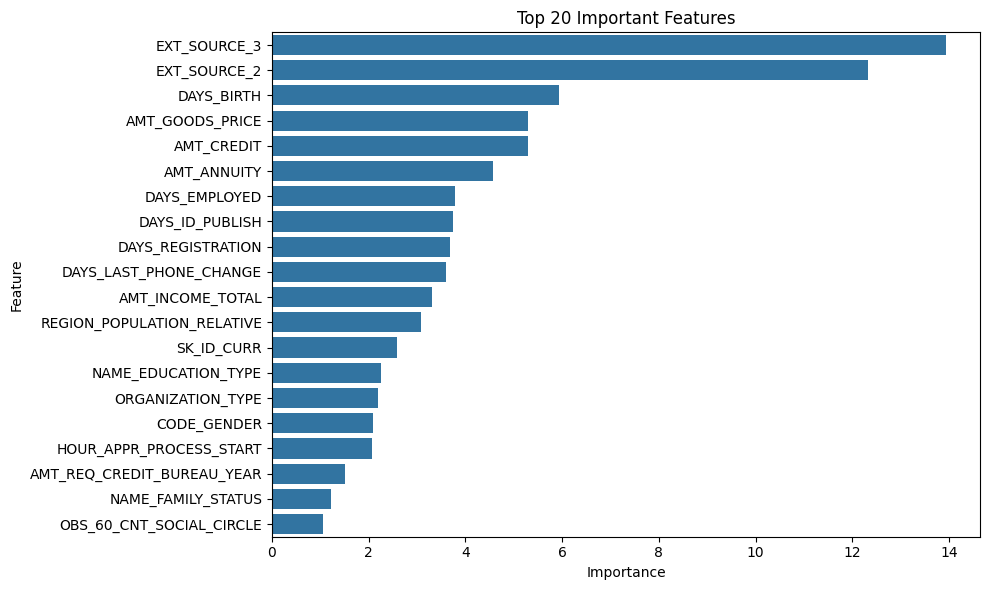

In [11]:
importances = cat_model.get_feature_importance()
features = X.columns

feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()
